In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cft
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import rc
rc('animation', html='html5')

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

import netCDF4 as nc
import datetime, time, os, sys
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
from netCDF4 import Dataset

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34899 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


## Preliminaries

In [6]:
nc_file = '/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/topog.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
topog_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
topog = topog_dataset.depth

nx, = topog.nx.shape
ny, = topog.ny.shape

nc_file = '/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/ocean_temp_salt.res.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
ocean_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))

coordx = ocean_dataset.GRID_X_T
coordy = ocean_dataset.GRID_Y_T

In [51]:
db = '/g/data/x77/db6174/access-om2/archive/databases/cc_database_2wf_checks_hourly.db'
session = cc.database.create_session(db)
expt = '025deg_jra55_ryf_nostress_cont_hourly'

In [111]:
tau_x = (cc.querying.getvar(expt = expt, session = session, variable = 'tau_x', frequency = '1 hourly')).isel(time = -1)
tau_y = (cc.querying.getvar(expt = expt, session = session, variable = 'tau_y', frequency = '1 hourly')).isel(time = -1)

x = tau_x.xu_ocean
y = tau_y.yu_ocean

X, Y = np.meshgrid(x, y)

### 1. North of 20$^{\circ}$ S is zero

In [49]:
y_max = -30
dy = 5

Text(0.5, 1.0, 'Latitudinal distribution of the wind stress mask')

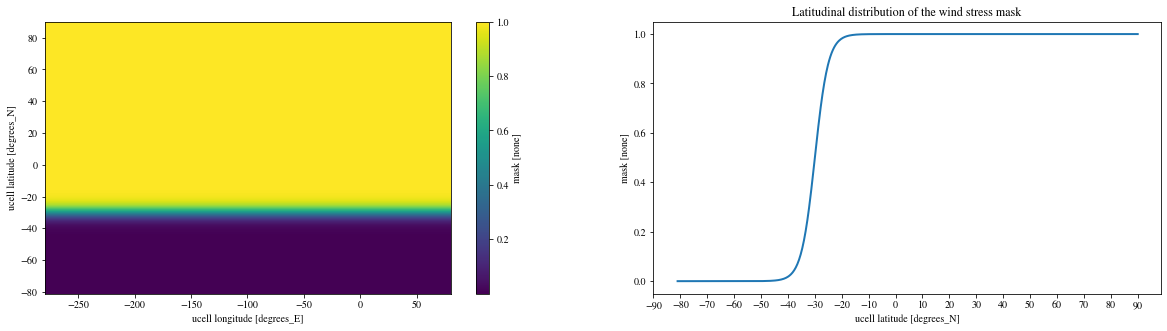

In [71]:
mask_tanh = 0.5 * np.tanh((Y - y_max)/dy) + 0.5
mask_20S = xr.DataArray(mask_tanh, coords = [y, x],  
                           dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})

fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))

mask_20S.plot(ax = axes[0])
plt.title('Spatial distribution of the wind stress mask')

mask_20S.sel(xu_ocean = 0, method = 'nearest').plot(ax = axes[1])
plt.xticks(np.linspace(-90, 90, 19))
plt.title('Latitudinal distribution of the wind stress mask')

### 2. North of equator is zero

In [72]:
y_max = 0
dy = 5

Text(0.5, 1.0, 'Latitudinal distribution of the wind stress mask')

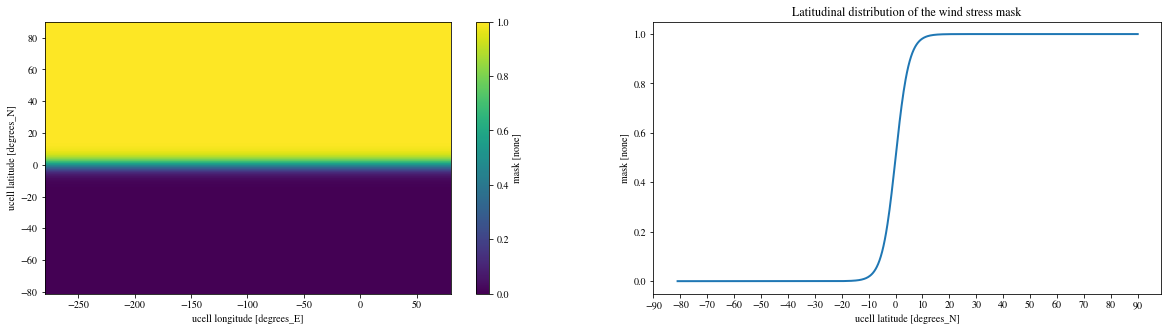

In [74]:
mask_tanh = 0.5 * np.tanh((Y - y_max)/dy) + 0.5
mask_0S = xr.DataArray(mask_tanh, coords = [y, x],  
                           dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})

fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))

mask_0S.plot(ax = axes[0])
plt.title('Spatial distribution of the wind stress mask')

mask_0S.sel(xu_ocean = 0, method = 'nearest').plot(ax = axes[1])
plt.xticks(np.linspace(-90, 90, 19))
plt.title('Latitudinal distribution of the wind stress mask')

### 3. North of 20$^{\circ}$ N is zero

In [78]:
y_max = 20
dy = 5

Text(0.5, 1.0, 'Latitudinal distribution of the wind stress mask')

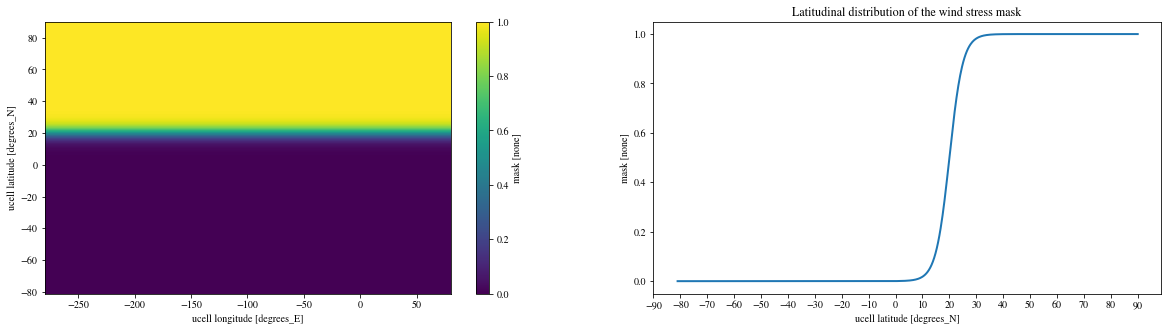

In [79]:
mask_tanh = 0.5 * np.tanh((Y - y_max)/dy) + 0.5
mask_20N = xr.DataArray(mask_tanh, coords = [y, x],  
                           dims = ['yu_ocean', 'xu_ocean'], name = 'mask', attrs = {'units':'none'})

fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))

mask_20N.plot(ax = axes[0])
plt.title('Spatial distribution of the wind stress mask')

mask_20N.sel(xu_ocean = 0, method = 'nearest').plot(ax = axes[1])
plt.xticks(np.linspace(-90, 90, 19))
plt.title('Latitudinal distribution of the wind stress mask')

## Plotting wind stress

Text(0.5, 1.0, 'x-direction stress - Winds present south of 20N')

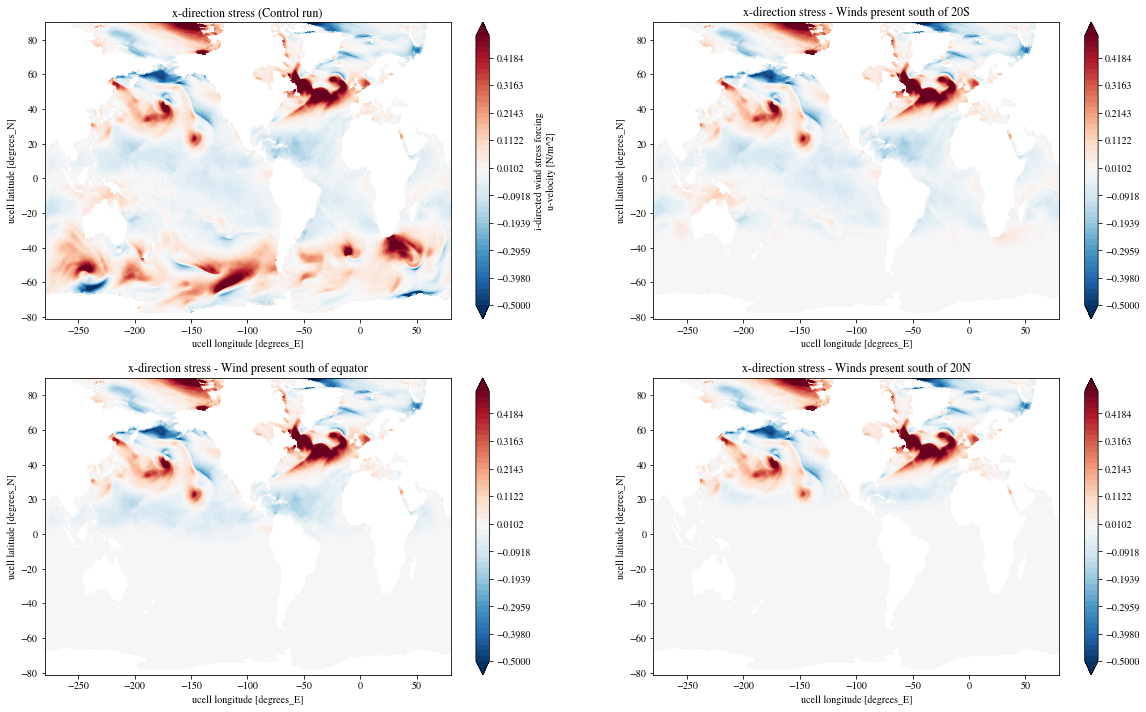

In [84]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

tau_x.plot.contourf(levels = np.linspace(-0.5, 0.5), ax = axes[0][0])
axes[0][0].set_title('x-direction stress (Control run)')

(tau_x*mask_20S).plot.contourf(levels = np.linspace(-0.5, 0.5), ax = axes[0][1])
axes[0][1].set_title('x-direction stress - Winds present south of 20S')

(tau_x*mask_0S).plot.contourf(levels = np.linspace(-0.5, 0.5), ax = axes[1][0])
axes[1][0].set_title('x-direction stress - Wind present south of equator')

(tau_x*mask_20N).plot.contourf(levels = np.linspace(-0.5, 0.5), ax = axes[1][1])
axes[1][1].set_title('x-direction stress - Winds present south of 20N')

Text(0.5, 1.0, 'y-direction stress - Winds present south of 20N')

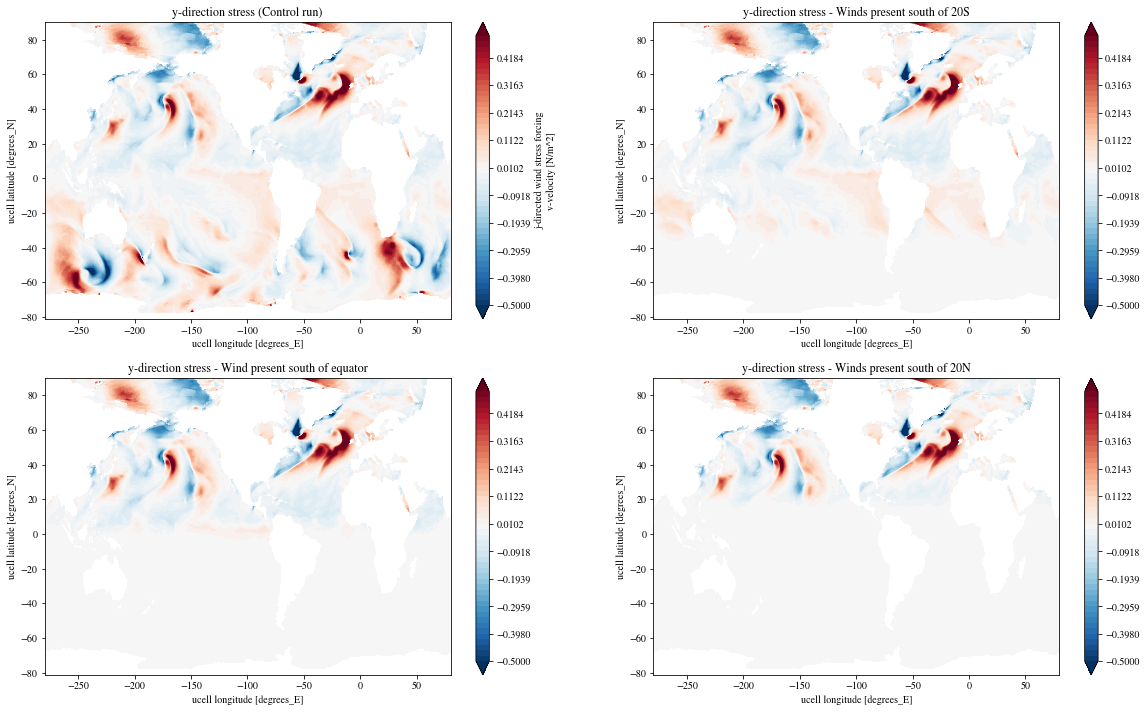

In [85]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

tau_y.plot.contourf(levels = np.linspace(-0.5, 0.5), ax = axes[0][0])
axes[0][0].set_title('y-direction stress (Control run)')

(tau_y*mask_20S).plot.contourf(levels = np.linspace(-0.5, 0.5), ax = axes[0][1])
axes[0][1].set_title('y-direction stress - Winds present south of 20S')

(tau_y*mask_0S).plot.contourf(levels = np.linspace(-0.5, 0.5), ax = axes[1][0])
axes[1][0].set_title('y-direction stress - Wind present south of equator')

(tau_y*mask_20N).plot.contourf(levels = np.linspace(-0.5, 0.5), ax = axes[1][1])
axes[1][1].set_title('y-direction stress - Winds present south of 20N')

## Plotting wind stress curl

In [98]:
import xgcm
print("xgcm version ", xgcm.__version__)

xgcm version  0.5.2


In [112]:
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')

tau_x_copy = tau_x
tau_y_copy = tau_y
tau_x_copy = tau_x_copy.rename('tau_x')
tau_y_copy = tau_y_copy.rename('tau_y')

ds = xr.merge([tau_x_copy, tau_y_copy, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid = xgcm.Grid(ds, periodic=['X'])

curl = ( grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
          - grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )

#curl = curl.rename('Relative Vorticity')
curl.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
curl.attrs['units'] = 's-1'

In [117]:
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')

tau_x_copy = tau_x*mask_20S
tau_y_copy = tau_y*mask_20S
tau_x_copy = tau_x_copy.rename('tau_x')
tau_y_copy = tau_y_copy.rename('tau_y')

ds = xr.merge([tau_x_copy, tau_y_copy, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid = xgcm.Grid(ds, periodic=['X'])

curl_20S = ( grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
          - grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )

#curl_20S = curl_20S.rename('Relative Vorticity')
curl_20S.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
curl_20S.attrs['units'] = 's-1'

In [118]:
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')

tau_x_copy = tau_x*mask_0S
tau_y_copy = tau_y*mask_0S
tau_x_copy = tau_x_copy.rename('tau_x')
tau_y_copy = tau_y_copy.rename('tau_y')

ds = xr.merge([tau_x_copy, tau_y_copy, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid = xgcm.Grid(ds, periodic=['X'])

curl_0S = ( grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
          - grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )

#curl_0S = curl_0S.rename('Relative Vorticity')
curl_0S.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
curl_0S.attrs['units'] = 's-1'

In [119]:
folder = '/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output000/ocean/'
grid = xr.open_mfdataset(folder+'ocean_grid.nc', combine='by_coords')

tau_x_copy = tau_x*mask_20N
tau_y_copy = tau_y*mask_20N
tau_x_copy = tau_x_copy.rename('tau_x')
tau_y_copy = tau_y_copy.rename('tau_y')

ds = xr.merge([tau_x_copy, tau_y_copy, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
grid = xgcm.Grid(ds, periodic=['X'])

curl_20N = ( grid.interp( grid.diff(ds.tau_y, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
          - grid.interp( grid.diff(ds.tau_x, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )

#curl_20N = curl_20N.rename('Relative Vorticity')
curl_20N.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
curl_20N.attrs['units'] = 's-1'

Text(0.5, 1.0, 'y-direction wind stress curl - Winds present south of 20N')

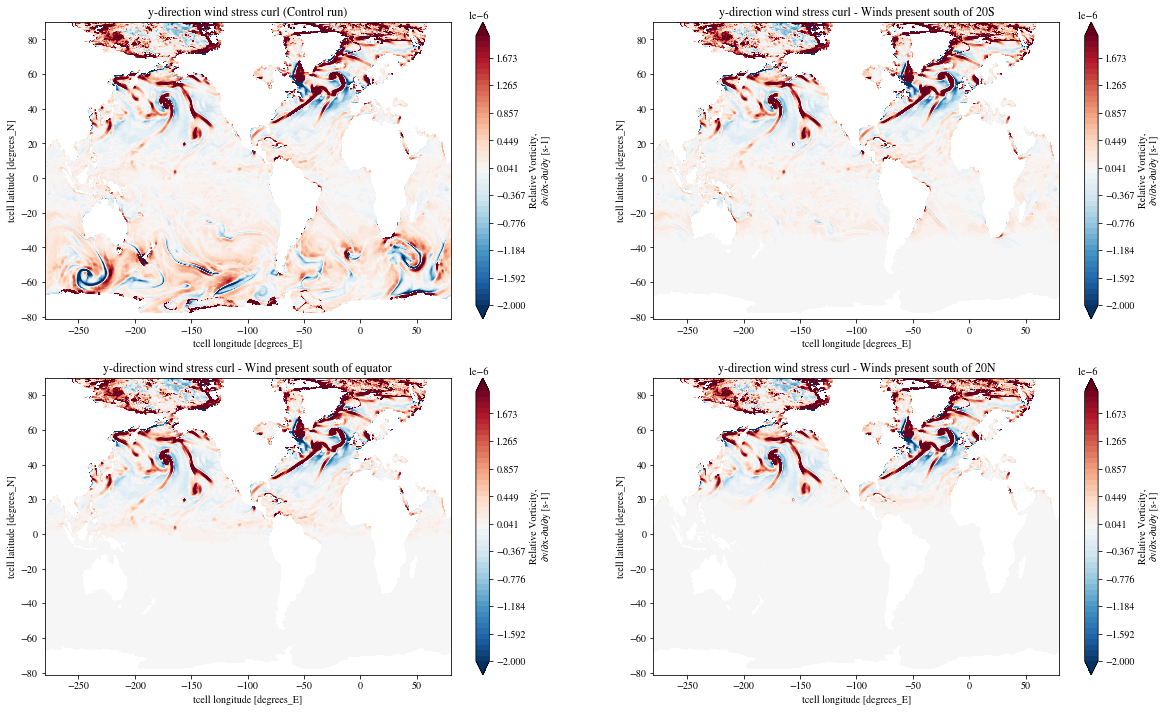

In [120]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

curl.plot.contourf(levels = np.linspace(-2e-6, 2e-6), ax = axes[0][0])
axes[0][0].set_title('y-direction wind stress curl (Control run)')

(curl_20S).plot.contourf(levels = np.linspace(-2e-6, 2e-6), ax = axes[0][1])
axes[0][1].set_title('y-direction wind stress curl - Winds present south of 20S')

(curl_0S).plot.contourf(levels = np.linspace(-2e-6, 2e-6), ax = axes[1][0])
axes[1][0].set_title('y-direction wind stress curl - Wind present south of equator')

(curl_20N).plot.contourf(levels = np.linspace(-2e-6, 2e-6), ax = axes[1][1])
axes[1][1].set_title('y-direction wind stress curl - Winds present south of 20N')